## データの؅管理：データのクリーニング、変換、マージ、再形成 (sqlite3編)

In [1]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas
import pandas as pd
np.set_printoptions(precision=4, threshold=500)
pd.options.display.max_rows = 100

In [3]:
%matplotlib inline

![](https://sqlite.org/images/sqlite370_banner.gif)
- DataFrameのマージ機能がデータベースっぽいので、比較してみる
 - データベースとして、軽量の**sqlite3**を使ってみる
 - ["Command Line Shell For Sqlite3"](https://sqlite.org/cli.html)
 <br><br>
- condaでインストールするのが一番簡単

```bash
conda install -c blaze sqlite3 
```

- 使い方(メモリーベース)

```python
import sqlite3
con = sqlite3.connect(":memory:");
```

 - ただし、例外が発生するとテーブルデータが怪しくなる
 - ちょっとした、お試しにはよいが脆弱なのでファイルベースが無難
 <br><br>

- 使い方(ファイルベース)

```python
import sqlite3
con = sqlite3.connect("test.sqlite3");
```

 - Auto Commmit on
 ```python
 con = sqlite3.connect("test.sqlite3", isolation_level = None)
 ```

- sqlite3 command tools

```bash
%SQLITE3_HOME%\sqlite3.exe test.sqlite3
```

## データセットのマージ

### データベース風のデータフレームのマージ

In [2]:
df1 = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                 'data1': range(7)})
df2 = DataFrame({'key': ['a', 'b', 'd'],
                 'data2': range(3)})
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [3]:
df2

,data2,key
0,0,a
1,1,b
2,2,d


- natural join (inner join) 相当

```sql
select * from df1 natural join df2
```

 - 同じ項目をキーとして、明示的に指定しない場合
 
- 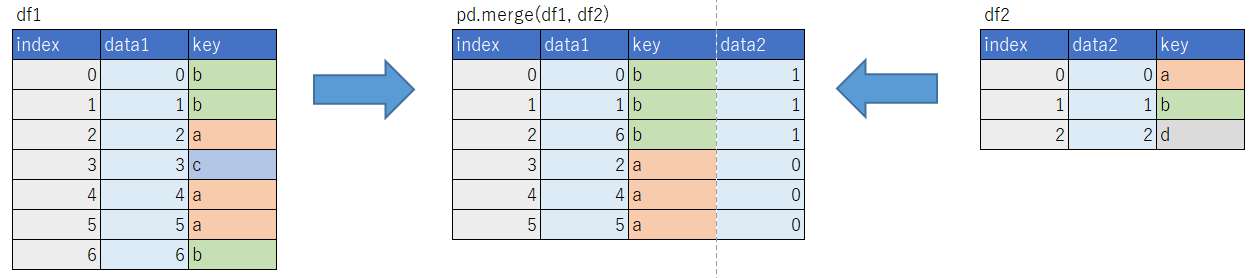

In [4]:
pd.merge(df1, df2)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


<hr>
<span style="color:blue">sqlite3</span>

In [14]:
import sqlite3

# テーブル定義 df1
con = sqlite3.connect(":memory:")
con.execute("create table if not exists df1(key text, data1 integer)")
con.execute("delete from df1")

In [15]:
# データ登録 df1
con.executemany("insert into df1 values(?,?)", df1[["key","data1"]].values)

- 上記は、以下と等価
```python
for d in df2[["key","data2"]].values:
    con.execute("insert into df2(key, data2) values(?, ?)", d)
```

In [16]:
# クエリー df1
df1db = pd.read_sql_query("select data1, key from df1", con)
df1db

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [17]:
# テーブル定義 df2
con.execute("create table if not exists df2(key text, data2 integer)")
con.execute("delete from df2")

In [18]:
# データ登録 df2
con.executemany("insert into df2 values(?,?)", df2[["key","data2"]].values)

In [19]:
df2db = pd.read_sql_query("select data2, key from df2", con)
df2db

,data2,key
0,0,a
1,1,b
2,2,d


- natural join (inner join) 相当

```sql
select * from df1 natural join df2
```

 - 同じ項目をキーとして、明示的に指定しない場合

In [20]:
dfdb = pd.read_sql_query("select data1, key, data2  from df1 natural join df2 order by key desc, data1", con)
dfdb

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [21]:
pd.merge(df1, df2)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


done!
<hr>

- inner join 相当

```sql
select * from df1 inner join df2 on df1.key=df2.key
```

or

```sql
select * from df1 inner join df2 using(key)
```

 - 右と左のキーが同じで、明示的に指定する場合 (on=)

In [22]:
pd.merge(df1, df2, on='key')

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [23]:
pd.read_sql_query("select data1, key, data2 from df1 join df2 using(key) order by key desc", con)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


<hr>

- inner join 相当

```sql
select * from df3 join df4 on df3.lkey=df4.rkey
```

 - 右と左を個別に、明示的に指定する場合 (left_key=, right_key=)

In [25]:
df3 = DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                 'data1': range(7)})
df4 = DataFrame({'rkey': ['a', 'b', 'd'],
                 'data2': range(3)})
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


<hr>
<span style="color:blue">sqlite3</span>

In [18]:
import sqlite3
con = sqlite3.connect(":memory:")

In [19]:
con.execute("create table if not exists df3(lkey text, data1 integer)")
con.execute("delete from df3");
con.executemany("insert into df3(lkey, data1) values(?,?)",df3[["lkey","data1"]].values)

In [20]:
con.execute("create table if not exists df4(rkey text, data2 integer)")
con.execute("delete from df4");
con.executemany("insert into df4(rkey, data2) values(?,?)",df4[["rkey","data2"]].values)

In [21]:
SQL = '''
select df3.data1, df3.lkey, df4.data2, df4.rkey 
from df3
join df4 
on df3.lkey=df4.rkey
order by df3.lkey desc
'''
df = pd.read_sql_query(SQL, con);
df

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


In [22]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


<hr>

- outer join 相当

- full outer join 相当
- sqlite3はfull outer join ができないので、left joinしてunion

```sql
select df1.data1, df1.key, df2.data2 from df1 left outer join df2 on df1.key=df2.key
union 
select df1.data1, df2.key, df2.data2 from df2 left outer join df1 on df1.key=df2.key
```

 - キーの和集合を取り、right joinとleft join の両方を適用したもの
 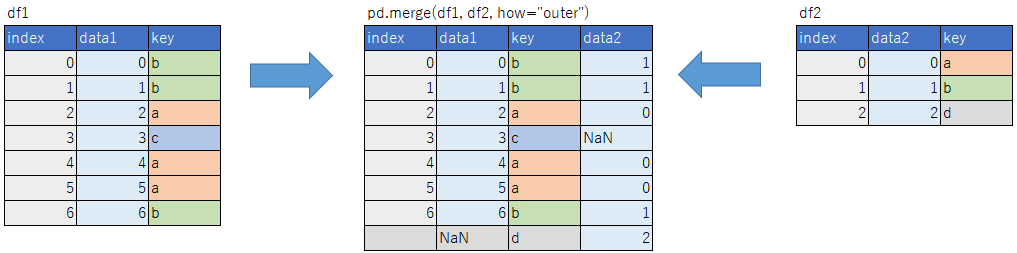

In [23]:
pd.merge(df1, df2, how='outer')

,data1,key,data2
0,0.0,b,1.0
1,1.0,b,1.0
2,6.0,b,1.0
3,2.0,a,0.0
4,4.0,a,0.0
5,5.0,a,0.0
6,3.0,c,NaN
7,NaN,d,2.0


<hr>
<span style="color:blue">sqlite3</span>

In [24]:
import sqlite3
con = sqlite3.connect(":memory:")

In [25]:
con.execute("create table if not exists df1(key text, data1 integer)")
con.execute("delete from df1");
con.executemany("insert into df1(key, data1) values(?,?)",df1[["key","data1"]].values)

In [26]:
con.execute("create table if not exists df2(key text, data2 integer)")
con.execute("delete from df2");
con.executemany("insert into df2(key, data2) values(?,?)",df2[["key","data2"]].values)

In [27]:
SQL = '''
select df1.data1, df1.key, df2.data2  from df1 left outer join df2 using(key)
union
select df1.data1, df2.key, df2.data2  from df2 left outer join df1 using(key)
'''
df = pd.read_sql_query(SQL, con);
df

,data1,key,data2
0,NaN,d,2.0
1,0.0,b,1.0
2,1.0,b,1.0
3,2.0,a,0.0
4,3.0,c,NaN
5,4.0,a,0.0
6,5.0,a,0.0
7,6.0,b,1.0


In [28]:
pd.merge(df1, df2, how='outer').sort_values(by=["data1"])

,data1,key,data2
0,0.0,b,1.0
1,1.0,b,1.0
3,2.0,a,0.0
6,3.0,c,NaN
4,4.0,a,0.0
5,5.0,a,0.0
2,6.0,b,1.0
7,NaN,d,2.0


<hr>

In [29]:
df1 = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                 'data1': range(6)})
df2 = DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                 'data2': range(5)})

In [30]:
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [31]:
df2

,data2,key
0,0,a
1,1,b
2,2,a
3,3,b
4,4,d


- left outer join 相当

```sql
select * from df1 left outer join df2 on df1.key=df2.key
```

 - 右と左のキーが同じものを、外部結合
 - left outer join と right outer join の和集合

In [32]:
pd.merge(df1, df2, on='key', how='left')

,data1,key,data2
0,0,b,1.0
1,0,b,3.0
2,1,b,1.0
3,1,b,3.0
4,2,a,0.0
5,2,a,2.0
6,3,c,NaN
7,4,a,0.0
8,4,a,2.0
9,5,b,1.0


<hr>
<span style="color:blue">sqlite3</span>

In [33]:
import sqlite3
con = sqlite3.connect(":memory:")

In [34]:
con.execute("create table if not exists df1(key text, data1 integer)")
con.execute("delete from df1");
con.executemany("insert into df1(key, data1) values(?,?)",df1[["key","data1"]].values)

In [35]:
con.execute("create table if not exists df2(key text, data2 integer)")
con.execute("delete from df2");
con.executemany("insert into df2(key, data2) values(?,?)",df2[["key","data2"]].values)

In [36]:
SQL = '''
select df1.data1, df1.key, df2.data2
from df1
left outer join df2
using(key)
'''
pd.read_sql_query(SQL, con)

,data1,key,data2
0,0,b,1.0
1,0,b,3.0
2,1,b,1.0
3,1,b,3.0
4,2,a,0.0
5,2,a,2.0
6,3,c,NaN
7,4,a,0.0
8,4,a,2.0
9,5,b,1.0


In [37]:
pd.merge(df1, df2, on='key', how='left').sort_values(by=["data1"])

,data1,key,data2
0,0,b,1.0
1,0,b,3.0
2,1,b,1.0
3,1,b,3.0
4,2,a,0.0
5,2,a,2.0
6,3,c,NaN
7,4,a,0.0
8,4,a,2.0
9,5,b,1.0


<hr>

- natural join 相当

```sql
select * from df1 natural join df2
```


In [38]:
pd.merge(df1, df2, how='inner')

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,5,b,1
5,5,b,3
6,2,a,0
7,2,a,2
8,4,a,0
9,4,a,2


<hr>
<span style="color:blue">sqlite3</span>

In [39]:
SQL = '''
select df1.data1, df1.key, df2.data2
from df1
inner join df2
using(key)
'''
pd.read_sql_query(SQL, con)

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,2,a,0
5,2,a,2
6,4,a,0
7,4,a,2
8,5,b,1
9,5,b,3


In [40]:
pd.merge(df1, df2, how='inner').sort_values(by=["data1"])

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
6,2,a,0
7,2,a,2
8,4,a,0
9,4,a,2
4,5,b,1
5,5,b,3


<hr>

- full outer join 相当

```sql
select l.key1, l.key2, l.lval, r.rval from left l left join right r using(key1,key2)
union
select r.key1, r.key2, l.lval, r.rval from right r left join left l using(key1,key2);
```

 - 右と左のキーが同じものを、外部結合
 - left outer join と right outer join の和集合を取り、right joinとleft join の両方を適用したもの

In [41]:
left = DataFrame({'key1': ['foo', 'foo', 'bar'],
                  'key2': ['one', 'two', 'one'],
                  'lval': [1, 2, 3]})
right = DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                   'key2': ['one', 'one', 'one', 'two'],
                   'rval': [4, 5, 6, 7]})
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


<hr>
<span style="color:blue">sqlite3</span>

In [42]:
import sqlite3
#con = sqlite3.connect(":memory:")
con = sqlite3.connect("test.sqlite3", isolation_level = None) # auto commit
con.execute("create table if not exists right( key1 text, key2 text, rval number)")
con.execute("create table if not exists left ( key1 text, key2 text, lval number)")
con.execute("delete from right")
con.execute("delete from left")
con.executemany("insert into left(key1, key2, lval)  values(?,?,?)",  left[["key1", "key2", "lval"]].values )
con.executemany("insert into right(key1, key2, rval) values(?,?,?)", right[["key1", "key2", "rval"]].values )

In [43]:
SQL = '''
select l.key1, l.key2, l.lval, r.rval from left l left join right r using(key1,key2)
union
select r.key1, r.key2, l.lval, r.rval from right r left join left l using(key1,key2)
'''
df = pd.read_sql_query(SQL, con);
df

,key1,key2,lval,rval
0,bar,one,3.0,6.0
1,bar,two,NaN,7.0
2,foo,one,1.0,4.0
3,foo,one,1.0,5.0
4,foo,two,2.0,NaN


- 何か変な感じです！
 - これだと、出力してくれません！、一度、変数に代入しないと表示されません
 
 ```python
pd.read_sql_query(SQL, con); 
 ```

In [44]:
pd.merge(left, right, on=['key1', 'key2'], how='outer').sort_values(["key1"])

,key1,key2,lval,rval
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN


- inner join 相当

```sql
select distinct l.key1, l.key2 as key2_x, l.lval, r.key2 as key2_y, r.rval from left l inner join right r using(key1);
```

In [45]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


- inner join 相当
```sql
select distinct l.key1, l.key2 as key2_left, l.lval, r.key2 as key2_right, r.rval from left l inner join right r using(key1);
```

In [46]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7
